# Module 6 Unsupervised Machine Learning Techniques on Healthcare Data

Yiheng Shen ys3323

This article is to perform two unsupervised learning techniques: unsupervised KNN and PCA with my improved 22 features, and analyze the result of anomalous providers.

### Undersampling

Due to the large volume of data, I used undersampling on the data

In [3]:
import numpy as np
import pandas as pd
from imblearn.under_sampling import RandomUnderSampler

#load cleaned data
df = pd.read_csv('healthcare_cleaned.csv')

In [6]:
y = df['Provider_Id'].copy()
rus = RandomUnderSampler(random_state=0)
data_resampled, y_resampled = rus.fit_sample(df, y)

In [7]:
len(data_resampled)

3337

### Encoding and Standardizing

In [8]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import  StandardScaler

In [15]:
#one hot encoder on df
ohe = OneHotEncoder(sparse = False)
category = ohe.fit_transform(data_resampled[['Provider_State']])
category = pd.DataFrame(category,index = data_resampled.index, columns = ohe.get_feature_names(),dtype = np.int8)

In [16]:
#standardize
numeric = data_resampled[data_resampled.columns[9:34]]
std = StandardScaler().fit_transform(numeric)
numeric = pd.DataFrame(std)
numeric.columns = data_resampled.columns[9:34].values 
data = pd.concat([category,numeric],axis=1)

## 1. unsupervised KNN

### Split Data

In [21]:
from sklearn.model_selection import train_test_split
X = data
X_train,X_test = train_test_split(X, random_state = 1)

### Hyper-Parameters

In [22]:
#train kNN detector
from pyod.models.knn import KNN
from pyod.models.combination import aom, moa, average, maximization
from pyod.utils.utility import standardizer

n_clf = 20
k_list = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 
 120, 130, 140, 150, 160, 170, 180, 190, 200]

train_scores = np.zeros([X_train.shape[0], n_clf])
test_scores = np.zeros([X_test.shape[0], n_clf])
train_scores.shape

# Modeling
for i in range(n_clf):
    k = k_list[i]
    clf = KNN(n_neighbors=k, method='largest')
    clf.fit(X_train)

# Store the results in each column:
    train_scores[:, i] = clf.decision_scores_
    test_scores[:, i] = clf.decision_function(X_test) 
    
# Decision scores have to be normalized before combination
train_scores, test_scores = standardizer(train_scores, test_scores)

### (1) Average Method Determination of Boundary

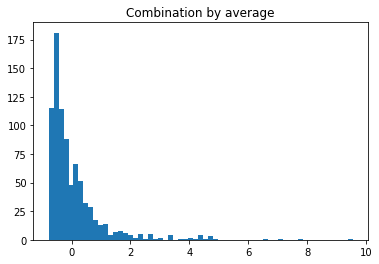

In [24]:
import matplotlib.pyplot as plt
y_by_average = average(test_scores)
plt.hist(y_by_average, bins = 'auto') # arguments are passed to np.histogram
plt.title("Combination by average")
plt.show()

In [43]:
#from the plot I think 2 will be a good threshold
df_test = pd.DataFrame(X_test)
df_test['y_by_average_score'] = y_by_average
df_test['y_by_average_cluster'] = np.where(df_test['y_by_average_score'] < 2, 0, 1)
df_test['y_by_average_cluster'].value_counts()

0    794
1     41
Name: y_by_average_cluster, dtype: int64

The number of "1" is 41, accounting for 4.91% of total.

### (2) Maximum of Maximum Method Determination of Boundary

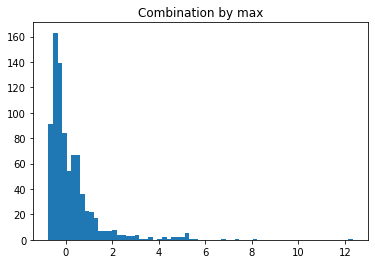

In [26]:
y_by_maximization = maximization(test_scores)
plt.hist(y_by_maximization, bins='auto')
plt.title("Combination by max")
plt.show()

In [28]:
#from the plot I think 2 will be a good threshold
df_test = pd.DataFrame(X_test)
df_test['y_by_maximization_score'] = y_by_maximization
df_test['y_by_maximization_cluster'] = np.where(df_test['y_by_maximization_score'] < 2, 0, 1)
df_test['y_by_maximization_cluster'].value_counts()

0    785
1     50
Name: y_by_maximization_cluster, dtype: int64

The number of "1" is 50, 6.02% of total.

### (3) The Average of Maximum Method Determination of Boundary

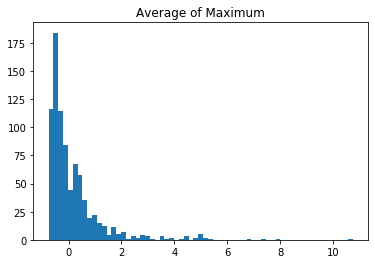

In [29]:
y_by_aom = aom(test_scores, n_buckets=5)

plt.hist(y_by_aom, bins='auto')  # arguments are passed to np.histogram
plt.title("Average of Maximum")
plt.show()

In [30]:
df_test = pd.DataFrame(X_test)
df_test['y_by_aom_score'] = y_by_aom
df_test['y_by_aom_cluster'] = np.where(df_test['y_by_aom_score'] < 2, 0, 1)
df_test['y_by_aom_cluster'].value_counts()

0    791
1     44
Name: y_by_aom_cluster, dtype: int64

The number of "1" is 44, accounting for 5.29% of total.

### (4) The Maximum of Average Method Determination of Boundary

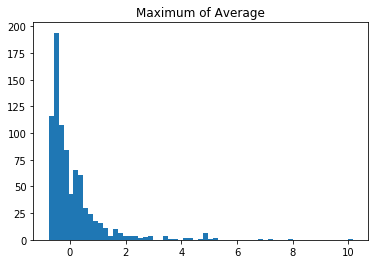

In [31]:
y_by_moa = moa(test_scores, n_buckets=5)

plt.hist(y_by_moa, bins='auto')
plt.title("Maximum of Average")
plt.show()

In [32]:
df_test['y_by_moa_score'] = y_by_moa
df_test['y_by_moa_cluster'] = np.where(df_test['y_by_moa_score'] < 2, 0, 1)
df_test['y_by_moa_cluster'].value_counts()

0    793
1     42
Name: y_by_moa_cluster, dtype: int64

The number of "1" is 42, accounting for 5.05% of total.

### Anomaly Analysis

In [33]:
df_test.groupby('y_by_average_cluster').mean().iloc[:,76:77]

,y_by_average_score
y_by_average_cluster,
0,-0.111068
1,3.734680


In [34]:
df_test.groupby('y_by_average_cluster').mean().iloc[:,78:79]

,y_by_maximization_cluster
y_by_average_cluster,
0,0.011335
1,1.000000


In [35]:
df_test.groupby('y_by_average_cluster').mean().iloc[:,80:81]

,y_by_aom_cluster
y_by_average_cluster,
0,0.003778
1,1.000000


In [36]:
df_test.groupby('y_by_average_cluster').mean().iloc[:,82:83]

,y_by_moa_cluster
y_by_average_cluster,
0,0.001259
1,1.000000


Four tables above show that Average Method is the best method for anomaly detection of this dataset, as the difference between the scores of cluster 0 and cluster 1 is the largest. So I attached the labels generated from Average Method back to the dataset.

In [37]:
y_train_by_average = average(train_scores)
X_train['y_by_average_score'] = y_train_by_average
X_train['y_by_average_cluster'] = np.where(X_train['y_by_average_score'] < 2, 0, 1)

/Users/yihengshen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/yihengshen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [45]:
X = pd.concat([X_train, X_test])

## PCA

In [48]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 5)
data_pca = pca.fit_transform(X)

In [49]:
np_scaled = StandardScaler().fit_transform(data_pca)
data_pca = pd.DataFrame(np_scaled)

In [50]:
data_pca = pd.DataFrame(data_pca)
data_pca.columns=["component_1", "component_2", "component_3", "component_4", "component_5"]
data_pca.head()

,component_1,component_2,component_3,component_4,component_5
0,-0.791142,0.089597,-0.245649,-0.462053,0.219637
1,0.324439,-1.494876,-0.221466,-0.044855,-0.615286
2,-0.482041,0.187190,0.102965,1.981746,0.510567
3,-0.766529,-0.304277,0.137760,0.043612,-0.352705
4,1.532964,1.408756,4.439574,0.698192,-1.268085


In [51]:
explained_variance = pca.explained_variance_ratio_
explained_variance

array([0.46251539, 0.21568862, 0.08541348, 0.07006037, 0.03876738])

The result of linear PCA is not ideal, so I try kernel (RBF) PCA then.

### Kernel PCA

In [52]:
reds = X['y_by_average_cluster'] == 0
blues = X['y_by_average_cluster'] == 1

In [53]:
from sklearn.decomposition import KernelPCA

kpca = KernelPCA(kernel = 'rbf', fit_inverse_transform = True, gamma = 10)
X_kpca = kpca.fit_transform(X)

Text(0, 0.5, '2nd component')

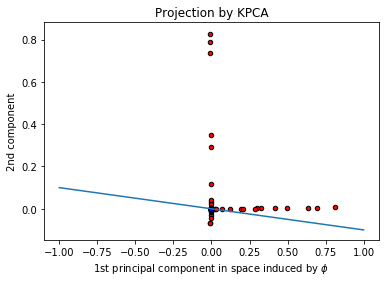

In [54]:
plt.scatter(X_kpca[reds, 0], X_kpca[reds, 1], c='red',s=20, edgecolor='k')
plt.scatter(X_kpca[blues, 0], X_kpca[blues, 1], c='blue',s=20, edgecolor='k')
x = np.linspace(-1, 1, 1000)
plt.plot(x, -0.1*x, linestyle= 'solid')
plt.title('Projection by KPCA')
plt.xlabel(r'1st principal component in space induced by $\phi$')
plt.ylabel('2nd component')

Not ideal, try linear kernel

Text(0, 0.5, '2nd component')

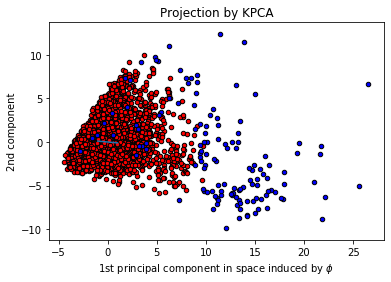

In [55]:
kpca = KernelPCA(kernel='linear', fit_inverse_transform=True, gamma=10)
X_kpca = kpca.fit_transform(X)
pca = PCA()
X_pca = pca.fit_transform(X)

plt.scatter(X_kpca[reds, 0], X_kpca[reds, 1], c='red',s=20, edgecolor='k')
plt.scatter(X_kpca[blues, 0], X_kpca[blues, 1], c='blue',s=20, edgecolor='k')
x = np.linspace(-1, 1, 1000)
plt.plot(x, -0.1*x, linestyle= 'solid')
plt.title('Projection by KPCA')
plt.xlabel(r'1st principal component in space induced by $\phi$')
plt.ylabel('2nd component')

above plot shows linear kernel well captures outliers. So I use the result of KNN as 

### Summary

In [62]:
data_resampled['y_by_average_cluster'] = X['y_by_average_cluster']
df_anomaly = data_resampled[data_resampled['y_by_average_cluster'] == 1]

In [69]:
df_anomaly['Provider_Name']

80                         BROOKWOOD MEDICAL CENTER
91                  JACK HUGHSTON MEMORIAL HOSPITAL
119     SCOTTSDALE HEALTHCARE-OSBORN MEDICAL CENTER
178                  BAXTER REGIONAL MEDICAL CENTER
187                  SPARKS REGIONAL MEDICAL CENTER
                           ...                     
3215                           BECKLEY ARH HOSPITAL
3295                        ST JOHNS MEDICAL CENTER
3322    FOUNDATION SURGICAL HOSPITAL OF SAN ANTONIO
3325                     ST LUKES LAKESIDE HOSPITAL
3332               WESTBURY COMMUNITY HOSPITAL, LLC
Name: Provider_Name, Length: 133, dtype: object

This list gives the 133 hospitals that overcharge.